# BidMPH v2 Monitor <br> Iquique y Alto Hospicio

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import os
# Add the monitor directory to Python path
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import pprint
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.download import download_bid_data_1, download_bid_data
from src.calculations import share_bidding_algorithm, share_bid_price_matches, share_available_prices_length, share_bid_price_matches_by_len

## Parameters

In [3]:
CITY_ID = 4231
CITY_NAME = 'San Louis Potossi'
ORDER_TYPE = 'auto_econom'

In [4]:
DATA_ROOT_PATH = pathlib.Path(f'data/city_id={CITY_ID}')
if not DATA_ROOT_PATH.exists():
    DATA_ROOT_PATH.mkdir(parents=True, exist_ok=True)

## Downlaoad

total

In [5]:
start_date = '2025-05-01'
end_date = '2025-06-20'

df_total = download_bid_data_1(start_date, end_date, CITY_ID, printBool=False)
df_total.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv', index=False)
print(f'df_total saved as {CITY_NAME}_total_bids.csv')

df_total saved as San Louis Potossi_total_bids.csv


df0 ('Before')

In [6]:
start_date = '2025-05-01'
end_date = '2025-05-19'

df0 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df0.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv', index=False)
print(
    'From', df0['utc_bid_dttm'].min(), 
    '\n to', df0['utc_bid_dttm'].max()
)
print(f'df0 saved as {CITY_NAME}_before_bids.csv')

From 2025-05-01 00:00:12+00:00 
 to 2025-05-19 23:59:55+00:00
df0 saved as San Louis Potossi_before_bids.csv


df1 ('Test')

In [7]:
start_date = '2025-05-20'
end_date = '2025-06-20'

df1 = download_bid_data(start_date, end_date, CITY_ID, printBool=False)
df1.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv', index=False)
print(
    'From', df1['utc_bid_dttm'].min(), 
    '\n to', df1['utc_bid_dttm'].max()
)
print(f'df1 saved as {CITY_NAME}_test_bids.csv')

From 2025-05-20 00:00:11+00:00 
 to 2025-06-06 06:51:04+00:00
df1 saved as San Louis Potossi_test_bids.csv


## Process Data

In [8]:
def parse_prices(s):
    if isinstance(s, str) and s.startswith('[') and s.endswith(']'):
        items = s.strip('[]').split()
        return [float(item) for item in items] if items and items[0] != '' else []
    else:
        return []  # для None или некорректных значений

total

In [9]:
df_total = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_total_bids.csv')

df_total = df_total[df_total['order_type'] == ORDER_TYPE]
df_total['bidding_algorithm_name'] = df_total['bidding_algorithm_name'].replace(np.nan, 'empty field')
# df_total['available_prices_currency'] = df_total['available_prices_currency'].apply(parse_prices)

In [10]:
# Убедитесь, что utc_bid_dttm — это datetime
df_total['utc_bid_dttm'] = pd.to_datetime(df_total['utc_bid_dttm'])

# Добавим колонку с датой (без времени)
df_total['date'] = df_total['utc_bid_dttm'].dt.date

# Группируем по дате и алгоритму, считаем количество
counts = df_total.groupby(['date', 'bidding_algorithm_name']).size().reset_index(name='count')

# Считаем общее количество по дням
total_per_day = df_total.groupby('date').size().reset_index(name='total')

# Объединяем, чтобы получить долю
counts = counts.merge(total_per_day, on='date')
counts['share'] = counts['count'] / counts['total']

# Пивотируем для удобства построения
pivot = counts.pivot(index='date', columns='bidding_algorithm_name', values='share').fillna(0)

df0

In [11]:
df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')
df0 = df0[df0['order_type'] == ORDER_TYPE]
df0['bidding_algorithm_name'] = df0['bidding_algorithm_name'].replace(np.nan, 'empty field')
df0['available_prices_currency'] = df0['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_90119/3278834597.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_before_bids.csv')


df1

In [12]:
df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')
df1 = df1[df1['order_type'] == ORDER_TYPE]
df1['bidding_algorithm_name'] = df1['bidding_algorithm_name'].replace(np.nan, 'empty field')
df1['available_prices_currency'] = df1['available_prices_currency'].apply(parse_prices)

/var/folders/6c/836pxtdj6t54m3v9r8r7z5fm0000gp/T/ipykernel_90119/1741608400.py:1: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(DATA_ROOT_PATH / f'{CITY_NAME}_test_bids.csv')


## Result

In [13]:
def format_dict(d, precision=4):
    return {k: round(v, precision) if isinstance(v, float) else v for k, v in d.items()}

total

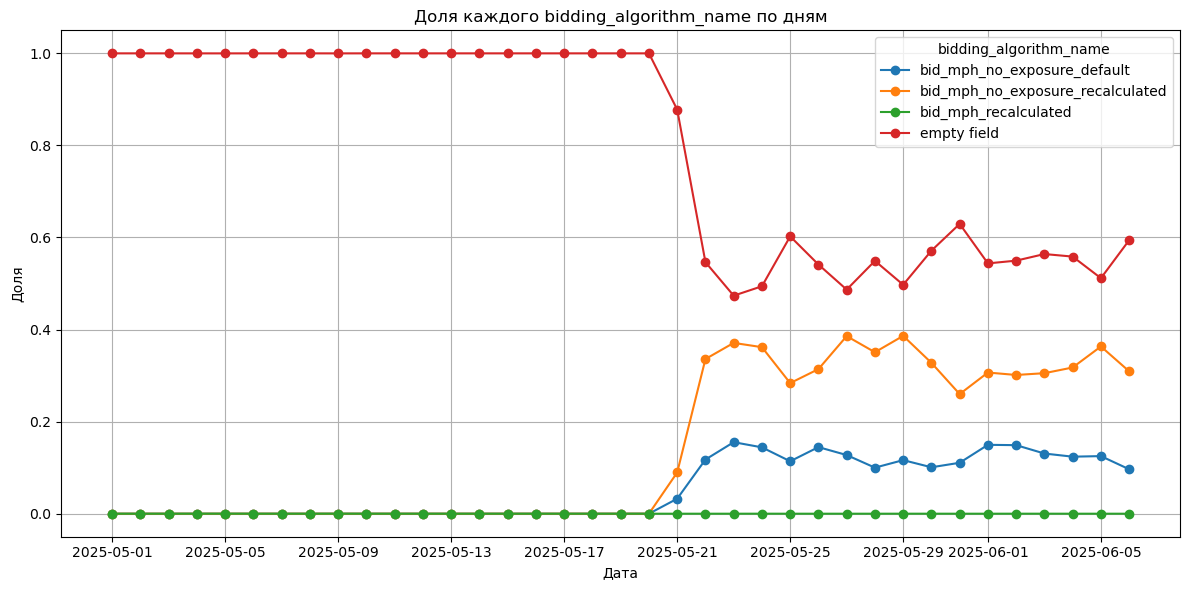

In [14]:
# Строим график
pivot.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Доля каждого bidding_algorithm_name по дням')
plt.ylabel('Доля')
plt.xlabel('Дата')
plt.grid(True)
plt.legend(title='bidding_algorithm_name')
plt.tight_layout()
plt.show()

df0

In [15]:
df0['bidding_algorithm_name'].unique()

array(['empty field', 'bid_mph_recalculated'], dtype=object)

In [16]:
share_algo = share_bidding_algorithm(df0)
share_matches = share_bid_price_matches(df0, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df0, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df0, algo_names=['empty field'], len_max=3)

In [17]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df0['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_recalculated': 0.0,
 'empty field': 1.0}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.0,
 'len_3': 1.0,
 'total': 1791079}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 1.0,
                'share': 0.0},
 'between_0_1': {'done_share': 0.3333,
                 'share': 0.0},
 'between_1_2': {'done_share': nan,
                 'share': 0.0},
 'match_first': {'done_share': 0.2683,
                 'share': 0.2273},
 'match_second': {'done_share': 0.1581,
                  'share': 0.2122},
 'match_sp': {'done_share': 0.6222,
              'share': 0.3283},
 'match_third': {'done_share': 0.0917,
                 'share': 0.2274}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_3': {'above_last': {'done_share': 1.0,
                          'share': 0.0},
           'between_0_1': {'done_share': 0.3333

In [18]:
print(
    len(df0[(df0['option_number'] == 'startprice') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 1') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 2') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    len(df0[(df0['option_number'] == 'option 3') & (df0['bidding_algorithm_name'] == 'empty field')])/len(df0[df0['bidding_algorithm_name'] == 'empty field']),
    )

0.33310255996525 0.22729315680659534 0.21218438717666838 0.22741710443816268


df1

In [19]:
df1['bidding_algorithm_name'].unique()

array(['empty field', 'bid_mph_no_exposure_recalculated',
       'bid_mph_no_exposure_default', 'bid_mph_recalculated'],
      dtype=object)

In [20]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['empty field'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['empty field'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['empty field'], len_max=3)

In [21]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.1138,
 'bid_mph_no_exposure_recalculated': 0.2983,
 'bid_mph_recalculated': 0.0,
 'empty field': 0.5878}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.0,
 'len_2': 0.0,
 'len_3': 1.0,
 'total': 861843}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': nan,
                'share': 0.0},
 'between_0_1': {'done_share': 0.6667,
                 'share': 0.0},
 'between_1_2': {'done_share': 1.0,
                 'share': 0.0},
 'match_first': {'done_share': 0.2791,
                 'share': 0.2209},
 'match_second': {'done_share': 0.1683,
                  'share': 0.2118},
 'match_sp': {'done_share': 0.6279,
              'share': 0.3224},
 'match_third': {'done_share': 0.0982,
                 'share': 0.2402}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_3': {'above_last': {'done_share': nan,
 

In [22]:
share_algo = share_bidding_algorithm(df1)
share_matches = share_bid_price_matches(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                         'bid_mph_no_exposure_default'], len_max=3)
share_lengths = share_available_prices_length(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                               'bid_mph_no_exposure_default'])
share_matches_by_len = share_bid_price_matches_by_len(df1, algo_names=['bid_mph_no_exposure_recalculated', 
                                                                       'bid_mph_no_exposure_default'], len_max=3)

In [23]:
print('Доля строк с нужным алгоритмом:')
pprint.pprint(format_dict(share_algo, 4), width=1)

print('Максимальное кол-во шагов:')
print(round(df1['available_prices_currency'].apply(len).max(), 0))

print('Доли длин available_prices_currency:')
pprint.pprint(format_dict(share_lengths, 4), width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:')
formatted_share_matches = {}
for k, v in share_matches.items():
    if isinstance(v, dict):
        formatted_share_matches[k] = {
            'share': round(v['share'], 4),
            'done_share': round(v['done_share'], 4)
        }
    else:
        formatted_share_matches[k] = round(v, 4)
pprint.pprint(formatted_share_matches, width=1)

print('Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:')
formatted_share_matches_by_len = {}
for len_key, len_dict in share_matches_by_len.items():
    formatted_share_matches_by_len[len_key] = {}
    for k, v in len_dict.items():
        if isinstance(v, dict):
            formatted_share_matches_by_len[len_key][k] = {
                'share': round(v['share'], 4),
                'done_share': round(v['done_share'], 4)
            }
        else:
            formatted_share_matches_by_len[len_key][k] = round(v, 4)
pprint.pprint(formatted_share_matches_by_len, width=1)

Доля строк с нужным алгоритмом:
{'bid_mph_no_exposure_default': 0.1138,
 'bid_mph_no_exposure_recalculated': 0.2983,
 'bid_mph_recalculated': 0.0,
 'empty field': 0.5878}
Максимальное кол-во шагов:
3
Доли длин available_prices_currency:
{'len_0': 0.0,
 'len_1': 0.4855,
 'len_2': 0.123,
 'len_3': 0.3915,
 'total': 604317}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов:
{'above_last': {'done_share': 1.0,
                'share': 0.0},
 'between_0_1': {'done_share': nan,
                 'share': 0.0},
 'between_1_2': {'done_share': nan,
                 'share': 0.0},
 'match_first': {'done_share': 0.2875,
                 'share': 0.3571},
 'match_second': {'done_share': 0.1585,
                  'share': 0.1405},
 'match_sp': {'done_share': 0.6225,
              'share': 0.3695},
 'match_third': {'done_share': 0.0948,
                 'share': 0.1281}}
Доли совпадений с SP/1/2/3 ценой и доли завершенных заказов внутри каждой длины:
{'len_1': {'above_last': {'done_share': 1

## !

In [24]:
columns = ['bid_uuid', 'etr', 'eta', 'price_highrate_value', 'price_start_value', 'bid_price_currency', 
           'steps_recalc_default', 'bidding_algorithm_name', 'available_prices_currency', 
           'steps_real_perc', 'max_bid']

t = 200
alpha = 0.1
steps_default_perc = [0.1, 0.2, 0.3]

In [25]:
def calculate_max_bid(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    # max_bid = (1+alpha) * max(Rec_price, Start_price) * (1 + (1+alpha) * max[0, (t2-t)]/(t1+t))
    max_bid = (1 + alpha) * max_price * (1 + time_diff_max / (t1 + t))

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [26]:
df_tmp = df1.sample(n=5).copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] != 'empty field'][columns].transpose()

,716716,1295589,1222819
bid_uuid,0196fef6-dd98-79b2-9704-9927a0dc9b0e,01972e9c-3521-7da5-8c4c-30f33c4b405b,01973761-a073-702b-817f-5c0e84f372c4
etr,873.0,368.0,480.0
eta,360,360,660
price_highrate_value,72.0,50.0,37.0
price_start_value,90.0,50.0,50.0
bid_price_currency,102.0,57.0,57.0
steps_recalc_default,"[99.00000000000001, 108.0, 117.0]","[55.00000000000001, 60.0, 65.0]","[55.00000000000001, 60.0, 65.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[102.0],[57.0],[57.0]
steps_real_perc,[1.1333333333333333],[1.14],[1.14]


Случай, где max_bid больше третьей опции, но bid_mph_no_exposure_recalculated <br>

In [27]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['case_check']].transpose()

,3,4,15,22,24,26,27,36,41,48,...,1471826,1471827,1471828,1471830,1471832,1471833,1471834,1471835,1471841,1471842
bid_uuid,0197062e-fc49-7069-99c1-e804a0dc5167,01970eba-a7fc-7200-b4b0-83ad60d99f0b,019727ab-59b8-7faa-9253-ea8e13f921fd,0197195e-b6e3-7c05-af34-f6f1a62e4065,019714f3-42bb-7c1f-a068-84ceca8f5652,01970f78-1f58-72b6-b63b-504945e1f748,019711db-3f18-7364-a968-222a6831a454,0196fa49-a104-797a-92f2-18cd577d36e3,0197046c-4b09-7cf2-b418-55136b9a36a7,01974242-9936-76ea-81bc-71abdbbdfb58,...,0196fea9-5397-7266-96e7-0c20a50bd401,0196ff4f-981c-7140-84a0-a28db120ace0,01970053-e2b3-7b01-8280-121987354831,01970052-e79e-7ac2-b8ce-fe20e46751f5,01970052-ea3e-7234-a488-101331adf43c,019703e8-ff26-7af8-9f2a-19ade783271a,0196ff66-4e7f-79cb-8073-0269606c23d8,019702e6-e99c-7513-924a-d098748e7b16,0196ff4f-9ad4-72fd-bd17-b32497e3d05a,0196fa9f-8b6a-7dd5-94e5-3cd0bf59cc48
etr,1977.0,343.0,1115.0,1086.0,277.0,1531.0,900.0,650.0,404.0,808.0,...,751.0,645.0,984.0,984.0,984.0,994.0,914.0,1297.0,645.0,1210.0
eta,60,240,300,300,240,120,180,240,120,540,...,120,300,300,300,120,420,300,420,240,360
price_highrate_value,184.0,36.0,117.0,66.0,36.0,118.0,84.0,59.0,47.0,98.0,...,92.0,66.0,105.0,105.0,105.0,100.0,118.0,114.0,66.0,100.0
price_start_value,184.0,50.0,100.0,65.0,41.0,118.0,70.0,59.0,62.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,120.0,100.0,100.0,100.0
bid_price_currency,184.0,50.0,132.0,65.0,47.0,133.0,95.0,59.0,62.0,113.0,...,100.0,100.0,119.0,100.0,100.0,115.0,120.0,100.0,100.0,100.0
steps_recalc_default,"[202.4, 220.79999999999998, 239.20000000000002]","[55.00000000000001, 60.0, 65.0]","[110.00000000000001, 120.0, 130.0]","[71.5, 78.0, 84.5]","[45.1, 49.199999999999996, 53.300000000000004]","[129.8, 141.6, 153.4]","[77.0, 84.0, 91.0]","[64.9, 70.8, 76.7]","[68.2, 74.39999999999999, 80.60000000000001]","[110.00000000000001, 120.0, 130.0]",...,"[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[132.0, 144.0, 156.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[207.0],[57.0],"[115.0, 125.0, 132.0]",[75.0],[47.0],[133.0],"[81.0, 88.0, 95.0]",[67.0],[70.0],[113.0],...,[113.0],[113.0],"[115.0, 119.0]","[115.0, 119.0]","[115.0, 119.0]","[115.0, 116.0]",[135.0],"[115.0, 125.0, 129.0]",[113.0],[113.0]
steps_real_perc,[1.125],[1.14],"[1.15, 1.25, 1.32]",[1.1538461538461537],[1.146341463414634],[1.1271186440677967],"[1.1571428571428573, 1.2571428571428571, 1.357...",[1.1355932203389831],[1.1290322580645162],[1.13],...,[1.13],[1.13],"[1.15, 1.19]","[1.15, 1.19]","[1.15, 1.19]","[1.15, 1.16]",[1.125],"[1.15, 1.25, 1.29]",[1.13],[1.13]


In [28]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.981631
                                  True          0.018369
bid_mph_no_exposure_recalculated  False         0.363088
                                  True          0.636912
bid_mph_recalculated              False         0.250000
                                  True          0.750000
empty field                       False         0.510591
                                  True          0.489409
dtype: float64

In [29]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)].sample(n=5)[columns].transpose()

,12902,56181,918427,1287365,315140
bid_uuid,01970317-d786-7b8b-b886-05422b764571,0196f540-8229-79d1-9741-ba21d4fcb705,019740ea-054b-72c1-981c-22953b5ffa7f,01971957-4ccf-7bf0-8cfb-fa9960a1c626,019735b3-4cec-7c8d-a614-e0f641ccbe45
etr,929.0,536.0,990.0,852.0,1363.0
eta,60,480,300,300,720
price_highrate_value,71.0,42.0,98.0,87.0,131.0
price_start_value,60.0,42.0,85.0,75.0,130.0
bid_price_currency,69.0,42.0,98.0,98.0,130.0
steps_recalc_default,"[66.0, 72.0, 78.0]","[46.2, 50.4, 54.6]","[93.50000000000001, 102.0, 110.5]","[82.5, 90.0, 97.5]","[143.0, 156.0, 169.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[69.0, 75.0, 80.0]",[49.0],"[98.0, 107.0, 111.0]","[87.0, 94.0, 98.0]",[148.0]
steps_real_perc,"[1.15, 1.25, 1.3333333333333333]",[1.1666666666666667],"[1.1529411764705881, 1.2588235294117647, 1.305...","[1.16, 1.2533333333333334, 1.3066666666666666]",[1.1384615384615384]


In [30]:
df_tmp[(df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated')
       & (df_tmp['case_check'] == False)]['bid_uuid'].to_csv('recalculated_false_cases.csv', index=False)

Sabr MaxBid

In [31]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = max(row['eta'], t)
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    if pd.isna(max_bid):
        return None
    else:
        return round(max_bid,4)

In [32]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,3,4,15,22,24,26,27,36,41,48,...,1471826,1471827,1471828,1471830,1471832,1471833,1471834,1471835,1471841,1471842
bid_uuid,0197062e-fc49-7069-99c1-e804a0dc5167,01970eba-a7fc-7200-b4b0-83ad60d99f0b,019727ab-59b8-7faa-9253-ea8e13f921fd,0197195e-b6e3-7c05-af34-f6f1a62e4065,019714f3-42bb-7c1f-a068-84ceca8f5652,01970f78-1f58-72b6-b63b-504945e1f748,019711db-3f18-7364-a968-222a6831a454,0196fa49-a104-797a-92f2-18cd577d36e3,0197046c-4b09-7cf2-b418-55136b9a36a7,01974242-9936-76ea-81bc-71abdbbdfb58,...,0196fea9-5397-7266-96e7-0c20a50bd401,0196ff4f-981c-7140-84a0-a28db120ace0,01970053-e2b3-7b01-8280-121987354831,01970052-e79e-7ac2-b8ce-fe20e46751f5,01970052-ea3e-7234-a488-101331adf43c,019703e8-ff26-7af8-9f2a-19ade783271a,0196ff66-4e7f-79cb-8073-0269606c23d8,019702e6-e99c-7513-924a-d098748e7b16,0196ff4f-9ad4-72fd-bd17-b32497e3d05a,0196fa9f-8b6a-7dd5-94e5-3cd0bf59cc48
etr,1977.0,343.0,1115.0,1086.0,277.0,1531.0,900.0,650.0,404.0,808.0,...,751.0,645.0,984.0,984.0,984.0,994.0,914.0,1297.0,645.0,1210.0
eta,60,240,300,300,240,120,180,240,120,540,...,120,300,300,300,120,420,300,420,240,360
price_highrate_value,184.0,36.0,117.0,66.0,36.0,118.0,84.0,59.0,47.0,98.0,...,92.0,66.0,105.0,105.0,105.0,100.0,118.0,114.0,66.0,100.0
price_start_value,184.0,50.0,100.0,65.0,41.0,118.0,70.0,59.0,62.0,100.0,...,100.0,100.0,100.0,100.0,100.0,100.0,120.0,100.0,100.0,100.0
bid_price_currency,184.0,50.0,132.0,65.0,47.0,133.0,95.0,59.0,62.0,113.0,...,100.0,100.0,119.0,100.0,100.0,115.0,120.0,100.0,100.0,100.0
steps_recalc_default,"[202.4, 220.79999999999998, 239.20000000000002]","[55.00000000000001, 60.0, 65.0]","[110.00000000000001, 120.0, 130.0]","[71.5, 78.0, 84.5]","[45.1, 49.199999999999996, 53.300000000000004]","[129.8, 141.6, 153.4]","[77.0, 84.0, 91.0]","[64.9, 70.8, 76.7]","[68.2, 74.39999999999999, 80.60000000000001]","[110.00000000000001, 120.0, 130.0]",...,"[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[132.0, 144.0, 156.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,[207.0],[57.0],"[115.0, 125.0, 132.0]",[75.0],[47.0],[133.0],"[81.0, 88.0, 95.0]",[67.0],[70.0],[113.0],...,[113.0],[113.0],"[115.0, 119.0]","[115.0, 119.0]","[115.0, 119.0]","[115.0, 116.0]",[135.0],"[115.0, 125.0, 129.0]",[113.0],[113.0]
steps_real_perc,[1.125],[1.14],"[1.15, 1.25, 1.32]",[1.1538461538461537],[1.146341463414634],[1.1271186440677967],"[1.1571428571428573, 1.2571428571428571, 1.357...",[1.1355932203389831],[1.1290322580645162],[1.13],...,[1.13],[1.13],"[1.15, 1.19]","[1.15, 1.19]","[1.15, 1.19]","[1.15, 1.16]",[1.125],"[1.15, 1.25, 1.29]",[1.13],[1.13]


In [33]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.981631
                                  True          0.018369
bid_mph_no_exposure_recalculated  False         0.363088
                                  True          0.636912
bid_mph_recalculated              False         0.250000
                                  True          0.750000
empty field                       False         0.510591
                                  True          0.489409
dtype: float64

Before experiment

In [34]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['max_bid_Sabr', 'case_check']].transpose()

""
bid_uuid
etr
eta
price_highrate_value
price_start_value
bid_price_currency
steps_recalc_default
bidding_algorithm_name
available_prices_currency
steps_real_perc


In [35]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name  case_check
bid_mph_recalculated    False         0.055556
                        True          0.944444
empty field             False         0.531532
                        True          0.468468
dtype: float64

Affected bids (not steps)

In [36]:
df_tmp = df0.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['bid_price_currency'], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns + ['max_bid_Sabr', 'case_check']].transpose()

,0,1,2,3,4,5,6,7,8,9,...,1800751,1800752,1800753,1800754,1800755,1800756,1800757,1800758,1800759,1800760
bid_uuid,0196c963-9c63-769b-a44f-9a7b3e6b401b,0196c71a-5f3d-78f0-bd49-065a8758a0d6,0196cace-8d34-7973-8e30-b44c24078272,0196c83b-47fa-7634-8f4e-d419ecc4d50e,0196ca62-6fb6-7fea-8442-d6059dfc4ed1,0196b665-d8c6-7bf2-ba56-8adcef9cf190,0196b737-4664-78ce-a60a-b2b92ad2bc9b,0196b613-b095-7553-9e55-d45e9dde4d8f,0196b6c7-50b8-762b-83f1-23c1d1862d1f,0196b5eb-7d5e-7ad0-bafc-25b1e7473987,...,0196c49c-56e7-7917-b7f1-94be46ec4a7d,0196d43f-c79f-7099-8994-4a3594561343,0196d613-64d9-7579-bf8b-59895edb24ff,0196d497-2d38-7a4f-a860-1e1a885e3f9b,0196d447-e175-70b2-804e-e65b5e5178eb,0196d1cf-a9f0-7422-b5e7-eed8bfba2d74,0196d194-cebd-7219-b95f-c2b048cc67f8,0196d154-fcc7-7950-8942-1f134172b9ba,0196d26d-6122-7c45-954b-97d0ecb5c2d6,0196d42f-1147-7991-96b2-08789bf1382b
etr,783.0,1098.0,805.0,578.0,855.0,884.0,626.0,1055.0,1021.0,441.0,...,573.0,409.0,808.0,498.0,998.0,335.0,381.0,1198.0,315.0,708.0
eta,480,360,300,240,300,420,480,120,660,300,...,420,300,360,300,360,120,180,420,240,180
price_highrate_value,104.0,127.0,75.0,85.0,51.0,93.0,51.0,114.0,115.0,47.0,...,78.0,49.0,98.0,35.0,96.0,39.0,35.0,93.0,42.0,56.0
price_start_value,80.0,67.0,75.0,70.0,51.0,90.0,56.0,114.0,115.0,47.0,...,78.0,40.0,70.0,35.0,80.0,39.0,35.0,75.0,42.0,55.0
bid_price_currency,80.0,91.0,88.0,81.0,51.0,90.0,76.0,114.0,156.0,55.0,...,78.0,50.0,95.0,35.0,100.0,49.0,35.0,95.0,49.0,68.0
steps_recalc_default,"[88.0, 96.0, 104.0]","[73.7, 80.39999999999999, 87.10000000000001]","[82.5, 90.0, 97.5]","[77.0, 84.0, 91.0]","[56.1, 61.199999999999996, 66.3]","[99.00000000000001, 108.0, 117.0]","[61.60000000000001, 67.2, 72.8]","[125.4, 136.79999999999998, 148.20000000000002]","[126.50000000000001, 138.0, 149.5]","[51.7, 56.4, 61.1]",...,"[85.80000000000001, 93.6, 101.4]","[44.0, 48.0, 52.0]","[77.0, 84.0, 91.0]","[38.5, 42.0, 45.5]","[88.0, 96.0, 104.0]","[42.900000000000006, 46.8, 50.7]","[38.5, 42.0, 45.5]","[82.5, 90.0, 97.5]","[46.2, 50.4, 54.6]","[60.50000000000001, 66.0, 71.5]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[92.0, 100.0, 108.0]","[78.0, 84.0, 91.0]","[81.0, 88.0, 95.0]","[81.0, 88.0, 95.0]","[59.0, 64.0, 69.0]","[104.0, 113.0, 122.0]","[65.0, 70.0, 76.0]","[132.0, 143.0, 154.0]","[133.0, 144.0, 156.0]","[55.0, 59.0, 64.0]",...,"[90.0, 98.0, 106.0]","[46.0, 50.0, 54.0]","[81.0, 88.0, 95.0]","[41.0, 44.0, 48.0]","[92.0, 100.0, 108.0]","[45.0, 49.0, 53.0]","[41.0, 44.0, 48.0]","[81.0, 88.0, 95.0]","[49.0, 53.0, 57.0]","[58.0, 63.0, 68.0]"
steps_real_perc,"[1.15, 1.25, 1.35]","[1.164179104477612, 1.2537313432835822, 1.3582...","[1.08, 1.1733333333333333, 1.2666666666666666]","[1.1571428571428573, 1.2571428571428571, 1.357...","[1.1568627450980393, 1.2549019607843137, 1.352...","[1.1555555555555554, 1.2555555555555555, 1.355...","[1.1607142857142858, 1.25, 1.3571428571428572]","[1.1578947368421053, 1.2543859649122806, 1.350...","[1.1565217391304348, 1.2521739130434784, 1.356...","[1.1702127659574468, 1.2553191489361701, 1.361...",...,"[1.1538461538461537, 1.2564102564102564, 1.358...","[1.15, 1.25, 1.35]","[1.1571428571428573, 1.2571428571428571, 1.357...","[1.1714285714285715, 1.2571428571428571, 1.371...","[1.15, 1.25, 1.35]","[1.1538461538461537, 1.2564102564102564, 1.358...","[1.1714285714285715, 1.2571428571428571, 1.371...","[1.08, 1.1733333333333333, 1.2666666666666666]","[1.1666666666666667, 1.2619047619047619, 1.357...","[1.0545454545454545, 1.1454545454545455, 1.236..."


In [37]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name  case_check
bid_mph_recalculated    False         0.944444
                        True          0.055556
empty field             False         0.801863
                        True          0.198137
dtype: float64

Choose Cities Query

In [38]:
def bids_data(start_date, stop_date, printBool=False):
    tmp_query = f"""
-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) AS first_row_by_accepted_tender,
    FROM `indriver-e6e40.emart.incity_detail`
    WHERE TRUE
        AND created_date_order_part >= DATE_SUB(DATE('{start_date}'), INTERVAL 1 DAY)
        AND created_date_order_part <= DATE_ADD(DATE('{stop_date}'), INTERVAL 1 DAY)
        AND DATE(TIMESTAMP(FORMAT_TIMESTAMP('%Y-%m-%d %H:%M:%S', order_timestamp), timezone)) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

incity_details_base AS (
  SELECT *
  FROM incity_details_raw
  WHERE first_row_by_accepted_tender = 1
),

avg_rta_per_city_type AS (
    SELECT
        city_id,
        order_type,
        AVG(TIMESTAMP_DIFF(driverarrived_timestamp, driveraccept_timestamp, SECOND)) AS avg_rta_seconds_t -- This is 't'
    FROM incity_details_base
    WHERE is_order_arrived = TRUE
    GROUP BY city_id, order_type
),

order_global_info AS (
    SELECT
        uuid AS order_uuid,
        MAX(multiplier) AS multiplier,
        MAX(price_highrate_value / COALESCE(multiplier, 100)) AS price_highrate_value,
        MAX(payment_price_value / COALESCE(multiplier, 100)) AS price_start_value
    FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm`
    WHERE uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) >= DATE('{start_date}') 
      AND DATE(created_at) <= DATE('{stop_date}')
    GROUP BY uuid
),

bids_raw AS (
    SELECT
        uuid AS bid_uuid,
        order_uuid,
        price AS bid_price_value,
        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64) AS t2_eta_seconds, -- This is 't2'
        created_at AS utc_bid_dttm
    FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
    WHERE status = 'BID_STATUS_ACTIVE'
      AND order_uuid IN (SELECT DISTINCT order_uuid FROM incity_details_base)
      AND DATE(created_at) BETWEEN DATE('{start_date}') AND DATE('{stop_date}')
),

bids_enriched AS (
    SELECT
        b_raw.bid_uuid,
        b_raw.order_uuid,
        b_raw.utc_bid_dttm,
        b_raw.t2_eta_seconds,
        idb.city_id,
        idb.order_type,
        idb.tender_uuid AS order_accepted_tender_uuid,
        idb.is_order_done,
        idb.t1_duration_seconds,
        ogi.price_highrate_value,
        ogi.price_start_value,
        idb.start_price_incity_usd, -- Start_price (from incity_detail, for reference or alternative)
        b_raw.bid_price_value / COALESCE(ogi.multiplier, 100) AS bid_price_value,
        art.avg_rta_seconds_t
    FROM bids_raw b_raw
    LEFT JOIN incity_details_base idb ON b_raw.order_uuid = idb.order_uuid
    LEFT JOIN order_global_info ogi ON b_raw.order_uuid = ogi.order_uuid
    LEFT JOIN avg_rta_per_city_type art ON idb.city_id = art.city_id AND idb.order_type = art.order_type
),

-- Evaluate bids based on the formula
evaluated_bids AS (
    SELECT
        be.*,
        av.alpha_value,
        -- max_permissible_bid formula: (1+alpha) * max(Rec_price, Start_price) * (1 + max(0, (t2-t))/(t1+t))
        ( (1 + av.alpha_value) * GREATEST(COALESCE(be.price_highrate_value, 0), COALESCE(be.price_start_value, 0)) * -- Using COALESCE for safety, though filters should handle NULLs
            (1 + GREATEST(0, COALESCE(be.t2_eta_seconds, 0) - COALESCE(be.avg_rta_seconds_t, 0)) /
                 NULLIF( (COALESCE(be.t1_duration_seconds, 0) + COALESCE(be.avg_rta_seconds_t, 0)) , 0)
            )
        ) AS max_permissible_bid
    FROM bids_enriched be
    CROSS JOIN alpha_values av
    WHERE be.price_highrate_value IS NOT NULL      
      AND be.price_start_value IS NOT NULL 
      AND be.t1_duration_seconds IS NOT NULL 
      -- avg_rta_seconds_t (t) can be null (coalesced to 0 in formula)
      -- t2_eta_seconds (t2) can be null (coalesced to 0 in formula)
),

bids_with_bad_status AS (
    SELECT
        *,
        (max_permissible_bid IS NOT NULL AND bid_price_value > max_permissible_bid) AS is_bad_bid
    FROM evaluated_bids
),

-- Metric 1: Доля плохих бидов
overall_bad_bid_share AS (
    SELECT
        city_id,
        order_type,
        avg_rta_seconds_t,
        alpha_value,
        COUNTIF(max_permissible_bid IS NOT NULL) AS total_bids_rule_applicable,
        SUM(CAST(is_bad_bid AS INT64)) AS count_bad_bids,
        SAFE_DIVIDE(SUM(CAST(is_bad_bid AS INT64)), COUNTIF(max_permissible_bid IS NOT NULL)) AS share_of_bad_bids
    FROM bids_with_bad_status
    GROUP BY city_id, order_type, avg_rta_seconds_t, alpha_value
),

-- Metric 2: Доля завершенных заказов с плохим принятым бидом
-- First, identify completed orders and if their accepted tender was bad
accepted_tender_evaluation AS (
    SELECT
        bws.order_uuid,
        bws.city_id,
        bws.order_type,
        bws.alpha_value,
        bws.is_order_done,
        bws.is_bad_bid AS is_accepted_tender_bad,
        (bws.max_permissible_bid IS NOT NULL) AS is_accepted_tender_rule_applicable
    FROM bids_with_bad_status bws
    WHERE bws.bid_uuid = bws.order_accepted_tender_uuid -- Focus on the accepted bid
      AND bws.is_order_done = TRUE -- Only completed orders
),

-- Count completed orders where the accepted tender was bad (and rule was applicable)
done_orders_with_bad_tender_counts AS (
    SELECT
        city_id,
        order_type,
        alpha_value,
        COUNTIF(is_accepted_tender_bad = TRUE AND is_accepted_tender_rule_applicable = TRUE) AS num_done_orders_with_bad_tender
    FROM accepted_tender_evaluation
    GROUP BY city_id, order_type, alpha_value
),

-- Denominator for Metric 2: Total completed orders for each city/type
all_completed_orders_count AS (
    SELECT
        city_id,
        order_type,
        COUNT(DISTINCT order_uuid) AS count_all_completed_orders
    FROM incity_details_base -- Filtered by date range
    WHERE is_order_done = TRUE
    GROUP BY city_id, order_type
),

-- Calculate final Metric 2
final_metric_done_orders_bad_tender AS (
    SELECT
        acoc.city_id,
        acoc.order_type,
        av.alpha_value, -- Ensure all alphas are present for each city/type
        acoc.count_all_completed_orders,
        COALESCE(dowbtc.num_done_orders_with_bad_tender, 0) AS num_done_orders_with_bad_tender,
        SAFE_DIVIDE(
            COALESCE(dowbtc.num_done_orders_with_bad_tender, 0),
            acoc.count_all_completed_orders
        ) AS share_done_orders_with_bad_tender -- Denominator is ALL completed orders
    FROM all_completed_orders_count acoc
    CROSS JOIN alpha_values av -- Ensures all alphas are present for every city/type
    LEFT JOIN done_orders_with_bad_tender_counts dowbtc
        ON acoc.city_id = dowbtc.city_id
        AND acoc.order_type = dowbtc.order_type
        AND av.alpha_value = dowbtc.alpha_value
)

-- Combine all metrics for the final output
SELECT
    COALESCE(m1.city_id, m2.city_id)            AS city_id,
    COALESCE(m1.order_type, m2.order_type)      AS order_type,
    m1.avg_rta_seconds_t                        AS avg_rta,
    COALESCE(m1.alpha_value, m2.alpha_value)    AS alpha_value,
    m1.total_bids_rule_applicable               AS bids_count,               
    m1.count_bad_bids                           AS bad_bids_count,
    m1.share_of_bad_bids                        AS bad_bids_share,
    m2.count_all_completed_orders               AS rides_count,
    m2.num_done_orders_with_bad_tender          AS rides_badbids_count,
    m2.share_done_orders_with_bad_tender        AS rides_badbids_share
FROM overall_bad_bid_share m1
FULL JOIN final_metric_done_orders_bad_tender m2
    ON m1.city_id = m2.city_id
    AND m1.order_type = m2.order_type
    AND m1.alpha_value = m2.alpha_value
ORDER BY
    city_id,
    order_type,
    alpha_value;
    """
    
    if printBool:
        print(tmp_query)
    # query = f"""
    # SELECT *
    # FROM `analytics-dev-333113.temp.df_tender_{user_name}_exp`
    # """

    return client.query(tmp_query).result().to_dataframe()

In [39]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

start_date = '2025-05-01'
end_date = '2025-05-19'

df0_choosecities = bids_data(start_date=start_date, stop_date=end_date, printBool = True)
df0_choosecities.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df0_choosecities.csv', index=False)

# city_id=CITY_ID, order_type=ORDER_TYPE


-- Замените 'YYYY-MM-DD' на ваши даты
-- DECLARE start_date DATE DEFAULT DATE('2023-01-01');
-- DECLARE stop_date DATE DEFAULT DATE('2023-01-02');

WITH
alpha_values AS (
    SELECT alpha_value
    FROM UNNEST([0.1, 0.125, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]) AS alpha_value
),

incity_details_raw AS (
    SELECT
        city_id,
        order_type,
        order_uuid,
        tender_uuid, -- Accepted bid's UUID for the order
        driveraccept_timestamp,
        driverarrived_timestamp,
        driverarrived_timestamp IS NOT NULL                                         AS is_order_arrived,
        driverdone_timestamp IS NOT NULL                                            AS is_order_done,
        price_start_usd AS start_price_incity_usd, -- Start_price from incity_detail
        duration_in_seconds AS t1_duration_seconds, -- This is t1
        ROW_NUMBER() OVER (
            PARTITION BY order_uuid 
            ORDER BY driveraccept_timestamp IS NULL, tender_timestamp ASC
        ) A

In [40]:
df0_choosecities[(df0_choosecities['city_id'] == CITY_ID) & 
                 (df0_choosecities['order_type'] == ORDER_TYPE)]

,city_id,order_type,avg_rta,alpha_value,bids_count,bad_bids_count,bad_bids_share,rides_count,rides_badbids_count,rides_badbids_share
3712,4231,auto_econom,271.974549,0.100,1774465,514167,0.289759,574260,88155,0.153511
3713,4231,auto_econom,271.974549,0.125,1774465,450448,0.253850,574260,76793,0.133725
3714,4231,auto_econom,271.974549,0.150,1774465,383552,0.216151,574260,65499,0.114058
3715,4231,auto_econom,271.974549,0.200,1774465,233789,0.131752,574260,33057,0.057565
3716,4231,auto_econom,271.974549,0.250,1774465,144156,0.081239,574260,20127,0.035049
3717,4231,auto_econom,271.974549,0.300,1774465,81501,0.045930,574260,10588,0.018438
3718,4231,auto_econom,271.974549,0.350,1774465,48906,0.027561,574260,7178,0.012500
3719,4231,auto_econom,271.974549,0.400,1774465,0,0.000000,574260,0,0.000000


OG bid approach

In [41]:
from google.cloud import bigquery
client = bigquery.Client(project='analytics-dev-333113')

def download_og_bid_data(start_date, stop_date, city_id, order_type, printBool=False):
    tmp_query = f"""
    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = {city_id}
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <INT64>) AS available_prices,
                          CAST(NULL AS INT64)         AS contractor_id,
                          CAST(NULL AS INT64)         AS eta,
                          duration_in_seconds         AS duration_in_seconds,
                          CAST(NULL AS STRING)        AS accepted_status,
                          type_name                   AS order_type,
                          CAST(NULL AS STRING)        AS bidding_algorithm_name
                   FROM `indriver-e6e40.ods_new_order_rh_cdc.order_global_strm` t1
                        LEFT JOIN timezone_data tz
                            ON t1.city_id = tz.city_id
                        LEFT JOIN (SELECT order_uuid,
                                          duration_in_seconds,
                                   FROM `indriver-e6e40.emart.incity_detail`
                                   WHERE true
                                     AND city_id = {city_id}
                                     AND created_date_order_part BETWEEN '{start_date}' AND '{stop_date}') t2
                            ON t1.uuid = t2.order_uuid  
                   WHERE true
                     AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                     AND created_at BETWEEN
                       TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), tz.timezone), INTERVAL 0 DAY)
                       AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), tz.timezone), INTERVAL 1
                                         DAY)
                     AND t1.city_id = {city_id}
                     AND type_name = '{order_type}'
                   QUALIFY ROW_NUMBER() OVER (PARTITION BY uuid, payment_price_value ORDER BY modified_at) = 1),

    accepted_bids AS (SELECT distinct
                             order_uuid AS order_uuid,
                             uuid       AS tender_uuid,
                             status     AS accepted_status,
                      FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm`
                      WHERE true
                        AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                          TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                          AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                        AND status = 'BID_STATUS_ACCEPTED'
                        AND order_uuid IN (SELECT order_uuid FROM rider_data)),
                        
    bid_data AS (SELECT distinct
                        CAST((ARRAY(SELECT DISTINCT city_id FROM rider_data LIMIT 1))[OFFSET(0)] AS INT64) AS city_id,
                        t.order_uuid                                                                       AS order_uuid,
                        price                                                                              AS price,
                        modified_at                                                                        AS modified_at_utc,
                        'bid_price'                                                                        AS price_type,
                        CAST(NULL AS INT64)                                                                AS price_highrate_value,
                        DENSE_RANK() OVER (ORDER BY t.order_uuid)                                          AS order_rn,
                        ROW_NUMBER() OVER (PARTITION BY t.order_uuid ORDER BY modified_at)                 AS tender_rn,
                        uuid                                                                               AS tender_uuid,
                        available_prices                                                                   AS available_prices,
                        contractor_id                                                                      AS contractor_id,
                        SAFE_CAST(SUBSTR(eta, 1, STRPOS(eta, 's') - 1) AS INT64)                           AS eta,
                        CAST(NULL AS INT64)                                                                AS duration_in_seconds,
                        accepted_status                                                                    AS accepted_status,
                        CAST(NULL AS STRING)                                                               AS order_type,
                        bidding_algorithm_name                                                             AS bidding_algorithm_name
                 FROM `indriver-e6e40.ods_new_order_rh_cdc.bid_global_strm` t
                 LEFT JOIN accepted_bids
                    ON t.order_uuid = accepted_bids.order_uuid
                        AND t.uuid = accepted_bids.tender_uuid
                 WHERE true
                   AND TIMESTAMP_TRUNC(created_at, DAY) BETWEEN
                     TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{start_date}')), INTERVAL -1 DAY)
                     AND TIMESTAMP_ADD(TIMESTAMP(PARSE_DATETIME('%Y-%m-%d', '{stop_date}')), INTERVAL 2 DAY)
                   AND status = 'BID_STATUS_ACTIVE'
                   AND t.order_uuid IN (SELECT order_uuid FROM rider_data)),

    your_table AS (SELECT *
                   FROM (SELECT *
                         FROM rider_data
                         UNION ALL
                         SELECT *
                         FROM bid_data)
                   ORDER BY order_uuid, modified_at_utc),

    pass_groups AS (SELECT order_uuid,
                           price,
                           modified_at_utc,
                           price_type,
                           SUM(CASE WHEN price_type = 'rider_price' THEN 1 ELSE 0 END)
                               OVER (PARTITION BY order_uuid ORDER BY modified_at_utc) AS pass_group,
                           price_highrate_value,
                           available_prices,
                           contractor_id,
                           tender_uuid,
                           city_id,
                           eta,
                           duration_in_seconds,
                           accepted_status,
                           bidding_algorithm_name
                    FROM your_table),

    full_data_table AS (SELECT city_id,
                               order_uuid,
                               price,
                               price_type,
                               modified_at_utc,
                               available_prices,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid, pass_group ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS last_pass_price,
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN price_highrate_value END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS price_highrate_value,
                               contractor_id,
                               tender_uuid,
                               eta, 
                               LAST_VALUE(CASE WHEN price_type = 'rider_price' THEN duration_in_seconds END IGNORE NULLS)
                                          OVER (PARTITION BY order_uuid ORDER BY modified_at_utc ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)
                                   AS duration_in_seconds,
                               accepted_status,
                               bidding_algorithm_name
                        FROM pass_groups),

    options_assign AS (SELECT *,
                              CASE
                                  WHEN price_type = 'rider_price' THEN NULL
                                  ELSE
                                      COALESCE(
                                              (SELECT CASE
                                                          WHEN price = last_pass_price
                                                              THEN 'startprice'
                                                          WHEN price = available_prices[offset]
                                                              THEN 'option ' || CAST(offset + 1 AS STRING)
                                                          WHEN price < available_prices[SAFE_OFFSET(0)]
                                                              THEN 'option 1-'
                                                          WHEN price >
                                                               available_prices[SAFE_OFFSET(ARRAY_LENGTH(available_prices) - 1)]
                                                              THEN 'option ' || CAST(ARRAY_LENGTH(available_prices) AS STRING) || '+'
                                                          ELSE 'option ' || CAST(offset + 1 AS STRING) ||
                                                               (CASE WHEN price > available_prices[offset] THEN '+' ELSE '-' END)
                                                          END
                                               FROM UNNEST(available_prices) WITH OFFSET AS offset
                                               WHERE price = available_prices[offset]
                                                  OR (price < available_prices[offset] AND
                                                      (offset = 0 OR price > available_prices[offset - 1]))
                                                  OR (price > available_prices[offset] AND
                                                      (offset = ARRAY_LENGTH(available_prices) - 1 OR
                                                       price < available_prices[offset + 1]))
                                               LIMIT 1),
                                              'other'
                                      ) END AS option_number
                       FROM full_data_table),

    result AS (SELECT *,
               FROM options_assign AS t
                        LEFT JOIN timezone_data tz
                                  ON t.city_id = tz.city_id
               WHERE price_type = 'bid_price')

    SELECT *
    FROM result
    WHERE DATETIME_TRUNC(modified_at_utc, DAY) BETWEEN
      TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{start_date}'), DAY))
      AND TIMESTAMP(DATETIME_TRUNC(PARSE_DATETIME('%Y-%m-%d', '{stop_date}'), DAY))
    ORDER BY modified_at_utc
    """

    if printBool:
        print(tmp_query)
    
    return client.query(tmp_query).result().to_dataframe()

In [42]:
start_date = '2025-05-20'
end_date = '2025-06-20'

df1_og = download_og_bid_data(start_date=start_date, stop_date=end_date, city_id=CITY_ID, order_type=ORDER_TYPE, printBool = True)
df1_og.to_csv(DATA_ROOT_PATH / f'{CITY_NAME}_df1_og.csv', index=False)


    WITH
    timezone_data AS (SELECT city_id,
                             timezone
                      FROM `indriver-e6e40.emart.incity_detail`
                      WHERE true
                        AND city_id = 4231
                        AND created_date_order_part = CURRENT_DATE()
                      LIMIT 1),

    rider_data AS (SELECT t1.city_id                  AS city_id,
                          uuid                        AS order_uuid,
                          payment_price_value         AS price,
                          modified_at                 AS modified_at_utc,
                          'rider_price'               AS price_type,
                          price_highrate_value        AS price_highrate_value,
                          CAST(NULL AS INT64)         AS order_rn,
                          CAST(NULL AS INT64)         AS tender_rn,
                          CAST(NULL AS STRING)        AS tender_uuid,
                          CAST(NULL AS ARRAY <

In [43]:
column_mapping = {
    'last_pass_price': 'price_start_value',
    'available_prices': 'available_prices_currency',
    'duration_in_seconds': 'etr',
    'price': 'bid_price_currency',
    'tender_uuid': 'bid_uuid'
}

df1_og = df1_og.rename(columns=column_mapping)
df1_og['bidding_algorithm_name'] = df1_og['bidding_algorithm_name'].replace('', 'empty field')

In [44]:
def calculate_max_bid_Sabr(row):
    t1 = row['etr']
    t2 = row['eta']
    rec_price = row['price_highrate_value']
    start_price = row['price_start_value']
    
    max_price = max(rec_price, start_price)
    time_diff_max = max(0, (t2 - t))
    
    max_bid = (1 + alpha) * max_price * (t1 + t2) / (t1 + t)

    return max_bid

In [45]:
df_tmp = df1_og.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid_Sabr'] = df_tmp.apply(calculate_max_bid_Sabr, axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)

df_tmp['case_check'] = df_tmp.apply(lambda x: x['max_bid_Sabr'] < x['steps_recalc_default'][-1], axis=1)

df_tmp[df_tmp['bidding_algorithm_name'] == 'bid_mph_no_exposure_recalculated'][columns + ['option_number', 'max_bid_Sabr', 'case_check']].transpose()

,114153,114154,114155,114156,114157,114158,114159,114160,114161,114162,...,1449736,1449737,1449738,1449740,1449743,1449744,1449745,1449746,1449748,1449749
bid_uuid,0196f400-a931-76bb-9014-427eb80cb5b9,0196f400-aa1d-7b9c-8b4c-04d6997c172a,0196f400-abd1-76bb-af90-c2817f141714,0196f400-bb02-7b9c-8dab-7d547046d714,0196f400-bc88-784e-9583-ad4d3bc845d4,0196f400-c01c-76bb-a03b-d40bc7527147,0196f400-c06e-784e-bbf4-2268eb37c794,0196f400-c467-76bb-9808-d1958d7c81f2,0196f400-c47e-7cfc-853c-66041431499a,0196f400-c640-7cfc-be2a-487222361d79,...,01974537-ca4d-7799-aa27-f26d52ce203c,01974537-d15d-7799-a0dc-56dd14e9d958,01974537-d3f4-7cf2-b9c0-4b0d5a0bb3a1,01974537-d930-7cf2-9300-c0e0cbff7da6,01974537-f27d-7799-bb2e-ed407e2974e2,01974537-f4d3-7799-8b35-e13d36001082,01974537-f50a-7799-a317-479fabd4e4ab,01974538-0559-7cf2-8a8d-74f10e92fcf8,01974538-0825-7cf2-ad94-2956d0236d2a,01974538-08df-7cf2-bf0b-9d8f5278f653
etr,971,538,900,638,727,1112,324,186,162,727,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
eta,360,240,420,240,300,300,360,480,360,480,...,420,180,600,300,300,660,420,300,660,240
price_highrate_value,8000.0,5000.0,8900.0,4400.0,5300.0,11500.0,3100.0,3000.0,2500.0,5300.0,...,7400.0,7300.0,17200.0,6500.0,2500.0,6500.0,NaN,5700.0,9200.0,8500.0
price_start_value,7000,5000,8900,5000,5300,11500,3100,3000,4000,5300,...,7400,7300,17200,6500,2500,7000,12500,5700,9200,7500
bid_price_currency,8800,5700,8900,5700,5300,11500,3100,3400,4000,6000,...,8800,7300,19800,6500,2900,7000,12500,6500,10600,9600
steps_recalc_default,"[7700.000000000001, 8400.0, 9100.0]","[5500.0, 6000.0, 6500.0]","[9790.0, 10680.0, 11570.0]","[5500.0, 6000.0, 6500.0]","[5830.000000000001, 6360.0, 6890.0]","[12650.000000000002, 13800.0, 14950.0]","[3410.0000000000005, 3720.0, 4030.0]","[3300.0000000000005, 3600.0, 3900.0]","[4400.0, 4800.0, 5200.0]","[5830.000000000001, 6360.0, 6890.0]",...,"[8140.000000000001, 8880.0, 9620.0]","[8030.000000000001, 8760.0, 9490.0]","[18920.0, 20640.0, 22360.0]","[7150.000000000001, 7800.0, 8450.0]","[2750.0, 3000.0, 3250.0]","[7700.000000000001, 8400.0, 9100.0]","[13750.000000000002, 15000.0, 16250.0]","[6270.000000000001, 6840.0, 7410.0]","[10120.0, 11040.0, 11960.0]","[8250.0, 9000.0, 9750.0]"
bidding_algorithm_name,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,...,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated,bid_mph_no_exposure_recalculated
available_prices_currency,"[8100, 8800, 9300]",[5700],[10100],[5700],[6000],[13000],[3500],[3400],[4500],[6000],...,"[8600, 8800]",[8300],"[19800, 21000]",[7400],[2900],[7900],[14100],[6500],"[10600, 11500, 11800]","[8700, 9400, 9600]"
steps_real_perc,"[1.1571428571428573, 1.2571428571428571, 1.328...",[1.14],[1.1348314606741574],[1.14],[1.1320754716981132],[1.1304347826086956],[1.1290322580645162],[1.1333333333333333],[1.125],[1.1320754716981132],...,"[1.162162162162162, 1.1891891891891893]",[1.1369863013698631],"[1.1511627906976745, 1.2209302325581395]",[1.1384615384615384],[1.16],[1.1285714285714286],[1.128],[1.1403508771929824],"[1.1521739130434783, 1.25, 1.2826086956521738]","[1.16, 1.2533333333333334, 1.28]"


In [46]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.947950
                                  True          0.052050
bid_mph_no_exposure_recalculated  False         0.349317
                                  True          0.650683
bid_mph_recalculated              False         0.250000
                                  True          0.750000
empty field                       False         0.492762
                                  True          0.507238
dtype: float64

Случай, где шаги бидов ниже старта: <br> bid_uuid == '0196f598-c67d-73b5-beb8-3bca5f30bc71'

In [47]:
df_tmp = df1.copy()
df_tmp['bidding_algorithm_name'] = df_tmp['bidding_algorithm_name'].replace('', 'empty field')

df_tmp['steps_real_perc'] = df_tmp.apply(lambda x: [price / x['price_start_value'] 
                                               for price in x['available_prices_currency']], axis=1)
df_tmp['max_bid'] = df_tmp.apply(calculate_max_bid, axis=1)
df_tmp['steps_recalc_default'] = df_tmp.apply(lambda x: [x['price_start_value'] * (1+ step_perc_def)
                                                  for step_perc_def in steps_default_perc], axis=1)
df_tmp['case_check'] = df_tmp.apply(lambda x: x['available_prices_currency'][0] / x['price_start_value'] < 1.1, axis=1)

columns += ['case_check']
df_tmp[df_tmp['bidding_algorithm_name'] == 'empty field'][columns].transpose()

,0,1,2,5,6,7,8,9,10,11,...,1471816,1471818,1471821,1471822,1471823,1471829,1471836,1471837,1471838,1471839
bid_uuid,019707a1-8067-7117-89cf-d9ba910c354a,01970864-5f3b-7986-b344-7662fd86bd92,01970550-c53b-7df5-8230-e78d4ec5906c,01970eea-1389-7388-ad6b-c4933b161c39,0196eddc-3fb1-7693-93a7-72f803612dc3,0196ebda-1d13-7f79-8d03-33ad266c46fb,0196effc-b285-7324-9d14-602b9a4b074c,0196efc0-c43f-72e1-971b-ee680de35a7a,0196ee94-d943-77f7-b5a4-7f9fa2574822,0196eed7-be31-71c6-92f2-41da05f3c266,...,0197006d-a354-7255-9098-6e121976bbb3,0196fd8d-b1d3-712e-bffe-582284fbbc6b,01970488-2b7c-7d81-9270-fe6e5fc97580,019700a6-d174-7292-937b-1e9f2fb200d3,019700a6-9b14-7305-bfd4-10d48e69cad6,019700aa-e0f3-7451-ac24-d66a2d463978,019700e8-79b6-7b60-b497-0774c8195c6c,0196fab7-e555-7120-8cb5-8d4a992a2468,0196fd52-c80b-7fc1-8bee-8efa3f3fc378,01970183-3122-73c0-91fe-123dd02c7ee3
etr,1081.0,1305.0,1201.0,754.0,969.0,798.0,629.0,872.0,580.0,981.0,...,1178.0,1263.0,951.0,896.0,896.0,896.0,1387.0,1358.0,1174.0,1514.0
eta,120,300,300,120,240,180,300,300,180,300,...,360,420,180,240,420,240,480,60,480,180
price_highrate_value,96.0,137.0,134.0,59.0,85.0,74.0,60.0,83.0,42.0,79.0,...,98.0,112.0,111.0,125.0,125.0,125.0,145.0,157.0,105.0,123.0
price_start_value,96.0,137.0,100.0,40.0,75.0,60.0,60.0,83.0,42.0,75.0,...,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,105.0,110.0
bid_price_currency,111.0,137.0,115.0,50.0,87.0,75.0,60.0,96.0,49.0,87.0,...,100.0,135.0,100.0,135.0,135.0,135.0,100.0,125.0,142.0,149.0
steps_recalc_default,"[105.60000000000001, 115.19999999999999, 124.8...","[150.70000000000002, 164.4, 178.1]","[110.00000000000001, 120.0, 130.0]","[44.0, 48.0, 52.0]","[82.5, 90.0, 97.5]","[66.0, 72.0, 78.0]","[66.0, 72.0, 78.0]","[91.30000000000001, 99.6, 107.9]","[46.2, 50.4, 54.6]","[82.5, 90.0, 97.5]",...,"[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[110.00000000000001, 120.0, 130.0]","[115.50000000000001, 126.0, 136.5]","[121.00000000000001, 132.0, 143.0]"
bidding_algorithm_name,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,...,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field,empty field
available_prices_currency,"[111.0, 120.0, 130.0]","[158.0, 172.0, 185.0]","[115.0, 125.0, 135.0]","[46.0, 50.0, 54.0]","[87.0, 94.0, 102.0]","[69.0, 75.0, 81.0]","[69.0, 75.0, 81.0]","[96.0, 104.0, 113.0]","[49.0, 53.0, 57.0]","[87.0, 94.0, 102.0]",...,"[115.0, 125.0, 135.0]","[115.0, 125.0, 135.0]","[115.0, 125.0, 135.0]","[115.0, 125.0, 135.0]","[115.0, 125.0, 135.0]","[115.0, 125.0, 135.0]","[115.0, 125.0, 135.0]","[115.0, 125.0, 135.0]","[121.0, 132.0, 142.0]","[127.0, 138.0, 149.0]"
steps_real_perc,"[1.15625, 1.25, 1.3541666666666667]","[1.1532846715328466, 1.2554744525547445, 1.350...","[1.15, 1.25, 1.35]","[1.15, 1.25, 1.35]","[1.16, 1.2533333333333334, 1.36]","[1.15, 1.25, 1.35]","[1.15, 1.25, 1.35]","[1.1566265060240963, 1.2530120481927711, 1.361...","[1.1666666666666667, 1.2619047619047619, 1.357...","[1.16, 1.2533333333333334, 1.36]",...,"[1.15, 1.25, 1.35]","[1.15, 1.25, 1.35]","[1.15, 1.25, 1.35]","[1.15, 1.25, 1.35]","[1.15, 1.25, 1.35]","[1.15, 1.25, 1.35]","[1.15, 1.25, 1.35]","[1.15, 1.25, 1.35]","[1.1523809523809523, 1.2571428571428571, 1.352...","[1.1545454545454545, 1.2545454545454546, 1.354..."


In [48]:
df_tmp.groupby(['bidding_algorithm_name', 'case_check']).size().groupby(level=0).transform(lambda x: x/x.sum())

bidding_algorithm_name            case_check
bid_mph_no_exposure_default       False         0.885116
                                  True          0.114884
bid_mph_no_exposure_recalculated  False         0.952978
                                  True          0.047022
bid_mph_recalculated              False         0.166667
                                  True          0.833333
empty field                       False         0.924820
                                  True          0.075180
dtype: float64